In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

frames_dir = "my_repo/asterix/frames"
labels_dir = "my_repo/asterix/heatmaps"
window_size = 4

normalisation_layer = tf.keras.layers.Rescaling(1./255)

train_frames = tf.keras.utils.image_dataset_from_directory(
  frames_dir,
  labels=None,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(84, 84),
  shuffle=False,
  batch_size=None,
  color_mode='grayscale',
  crop_to_aspect_ratio=False,
)

train_frames = train_frames.window(window_size, shift=1, drop_remainder=True)
train_frames = train_frames.flat_map(lambda window: window).batch(4)
train_frames = train_frames.map(lambda x: tf.squeeze(x, axis=-1))

train_labels = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  labels=None,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(84, 84),
  shuffle=False,
  batch_size=None,
  color_mode='grayscale',
  crop_to_aspect_ratio=False,
)

train_labels = train_labels.map(lambda x: (normalisation_layer(x)))
train_labels = train_labels.map(lambda x: tf.squeeze(x, axis=-1))


val_frames = tf.keras.utils.image_dataset_from_directory(
  frames_dir,
  labels=None,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(84, 84),
  shuffle=False,
  batch_size=None,
  color_mode='grayscale',
  crop_to_aspect_ratio=False,
)

val_frames = val_frames.window(window_size, shift=1, drop_remainder=True)
val_frames = val_frames.flat_map(lambda window: window).batch(4)
val_frames = val_frames.map(lambda x: tf.squeeze(x, axis=-1))

val_labels = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  labels=None,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(84, 84),
  shuffle=False,
  batch_size=None,
  color_mode='grayscale',
  crop_to_aspect_ratio=False,
)

val_labels = val_labels.map(lambda x: (normalisation_layer(x)))
val_labels = val_labels.map(lambda x: tf.squeeze(x, axis=-1))
        
train_ds = tf.data.Dataset.zip((train_frames, train_labels))
val_ds = tf.data.Dataset.zip((val_frames, val_labels))

train_ds = train_ds.shuffle(1000).batch(256).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(1000).batch(256).prefetch(tf.data.AUTOTUNE)

Found 31198 files belonging to 1 classes.
Using 24959 files for training.
Found 31198 files belonging to 1 classes.
Using 24959 files for training.
Found 31198 files belonging to 1 classes.
Using 6239 files for validation.
Found 31198 files belonging to 1 classes.
Using 6239 files for validation.


In [3]:
import numpy as np
for frames, labels in train_ds.take(1):
    print(frames.shape, labels.shape)
    heatmap = labels[0]
    # Pixel values are now in `[0,1]`
    print(np.min(heatmap), np.max(heatmap))

(256, 4, 84, 84) (256, 84, 84)
0.0 0.99292725


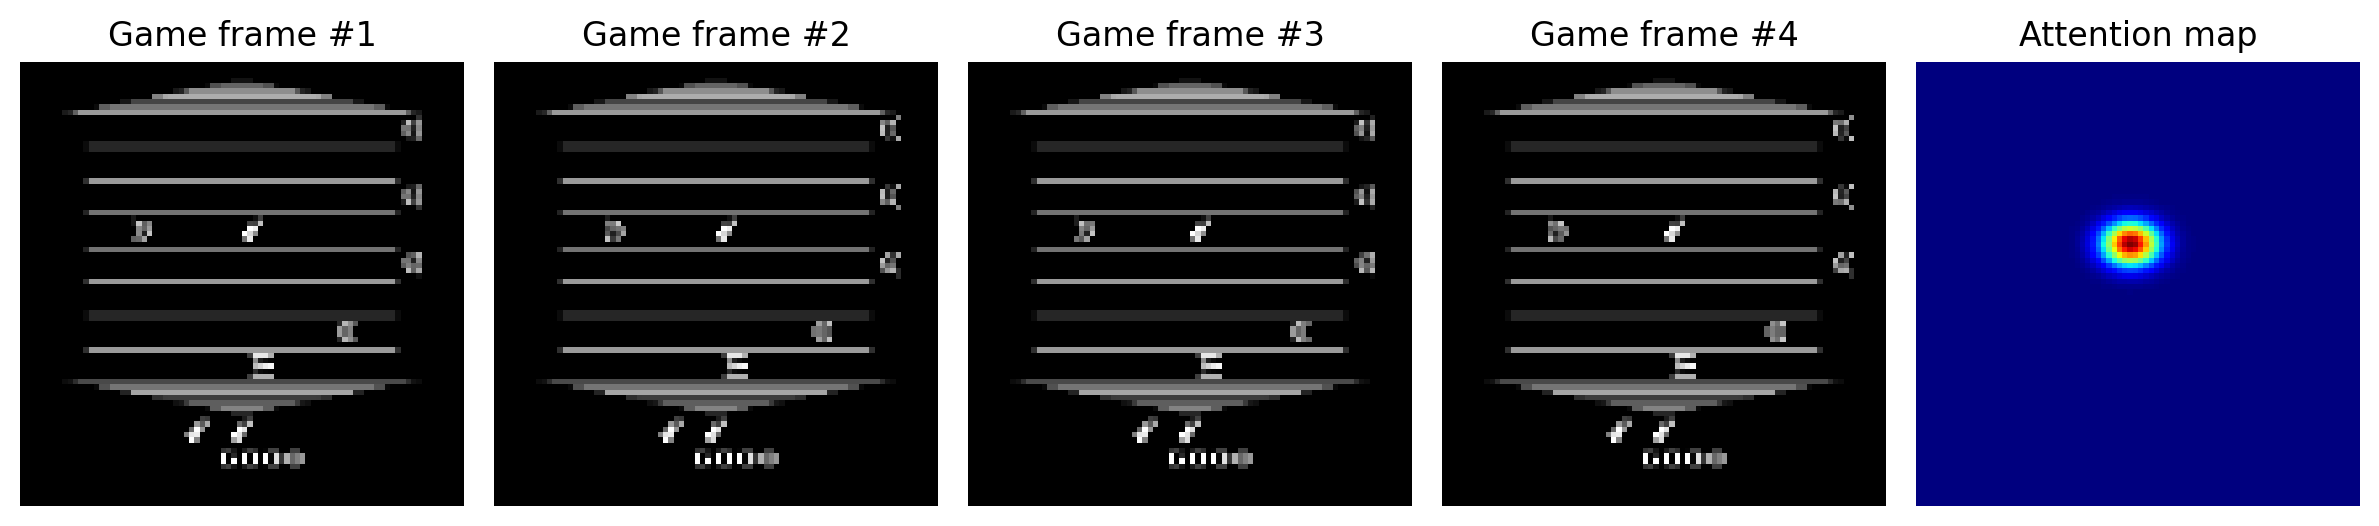

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))
ax = ax.ravel()
for frames, labels in val_ds.take(1):
    for i in range(4):
        ax[i].imshow(frames[20][i], cmap='gray')
        ax[i].set_title(f'Game frame #{i + 1}')
        ax[i].axis("off")

    ax[4].imshow(labels[20], cmap='jet')
    ax[4].set_title('Attention map')  
    ax[4].axis("off");
fig.tight_layout()

In [7]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, \
BatchNormalization, Softmax, Activation

class GazePrediction(Model):
    def __init__(self, env, frame_stack=4):
        super().__init__()
        input_channels = frame_stack
        self.conv1     = Conv2D(filters=32, kernel_size=(8, 8), strides=4,
                                padding='valid', activation=None,
                                kernel_initializer='he_normal')
        self.norm1     = BatchNormalization()
        self.relu1     = Activation(tf.nn.relu)
        
        self.conv2     = Conv2D(filters=64, kernel_size=(4, 4), strides=2,
                                padding='valid', activation=None,
                                kernel_initializer='he_normal')
        self.norm2     = BatchNormalization()
        self.relu2     = Activation(tf.nn.relu)
        
        self.conv3     = Conv2D(filters=64, kernel_size=(3, 3), strides=1,
                                padding='valid', activation=None,
                                kernel_initializer='he_normal')
        self.norm3     = BatchNormalization()
        self.relu3     = Activation(tf.nn.relu)

        self.deconv1   = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=1,
                                padding='valid', activation=None,
                                kernel_initializer='he_normal')
        self.norm4     = BatchNormalization()
        self.relu4     = Activation(tf.nn.relu)
        
        self.deconv2   = Conv2DTranspose(filters=32, kernel_size=(4, 4), strides=2,
                                padding='valid', activation=None,
                                kernel_initializer='he_normal')
        self.norm5     = BatchNormalization()
        self.relu5     = Activation(tf.nn.relu)
        
        self.deconv3   = Conv2DTranspose(filters=1, kernel_size=(8, 8), strides=4,
                                padding='valid', activation=None,
                                kernel_initializer='he_normal')
        self.norm6     = BatchNormalization()
        self.relu6     = Activation(tf.nn.relu)
        self.softmax   = Softmax()

    def call(self, obs, training=True):
        input_shape = tf.shape(obs)
        obs = tf.transpose(obs, [0, 2, 3, 1]) # make channels last: NCHW doesn't work on M1 chip
        obs = obs / 0xFF
        output = self.conv1(obs, training=training)
        output = self.norm1(output, training=training)
        output = self.relu1(output, training=training)
        output = self.conv2(output, training=training)
        output = self.norm2(output, training=training)
        output = self.relu2(output, training=training)
        output = self.conv3(output, training=training)
        output = self.norm3(output, training=training)
        output = self.relu3(output, training=training)

        output = self.deconv1(output, training=training)
        output = self.norm4(output, training=training)
        output = self.relu4(output, training=training)
        output = self.deconv2(output, training=training)
        output = self.norm5(output, training=training)
        output = self.relu5(output, training=training)
        output = self.deconv3(output, training=training)
        output = self.norm6(output, training=training)
        output = self.relu6(output, training=training)
        output = self.softmax(tf.reshape(output, [-1]))
        
        return tf.reshape(output, (input_shape[0], input_shape[2], input_shape[3]))

In [ ]:
@tf.function
def train_step(model, inputs, targets, loss_fn, optimiser, loss_metric):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(gradients, model.trainable_variables))
    logs = {}
    loss_metric.update_state(targets, predictions)
    logs["loss"] = loss_metric.result()
    return logs
    
@tf.function
def test_step(inputs, targets, loss_fn, loss_metric):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    logs = {}
    loss_metric.update_state(targets, predictions)
    logs["val_loss"] = loss_metric.result()
    return logs, predictions

In [ ]:
import tensorflow as tf
# from model import GazePrediction
import gym
from gym.wrappers import FrameStack, AtariPreprocessing
import numpy as np
from tensorflow.keras.optimizers import Adam, Adadelta

env = gym.make('ALE/Asterix-v5', frameskip=1)
env = AtariPreprocessing(env, frame_skip=4)
# frame stacking with 4 frames
env = FrameStack(env, num_stack=4)

tf.keras.backend.clear_session()

# Hyperparameters
epochs = 250
learning_rate = 0.001

# Initialize the model
model = GazePrediction(env)
loss_fn = tf.keras.losses.KLDivergence()
optimiser = Adam(learning_rate=learning_rate)
# optimiser = Adadelta(learning_rate=0.1)

# Metrics
loss_metric = tf.keras.metrics.KLDivergence()
hist = {'loss': [], 'val_loss': []}

def reset_metrics(metrics):
    """Utility function to reset the state of metrics"""
    for metric in metrics:
        metric.reset_state()

examples = {"prediction": [], "target": []}

# training
for epoch in range(epochs):
    reset_metrics([loss_metric])
    for inputs, targets in train_ds:
        logs = train_step(model, inputs, targets, loss_fn, optimiser, loss_metric)
    for key, value in logs.items():
        hist[key].append(value)
        if epoch % 20 == 0:
            print(f"Results at the end of epoch {epoch}: \n...{key}: {value:.4f}")

    # test
    reset_metrics([loss_metric])
    for inputs, targets in val_ds:
        logs, predictions = test_step(inputs, targets, loss_fn, loss_metric)
    id = np.random.randint(12)
    examples["prediction"].append(predictions[id])
    examples["target"].append(targets[id])
    for key, value in logs.items():
        hist[key].append(value)
        if epoch % 20 == 0:
            print("...Evaluation results:")
            print(f"...{key}: {value:.4f}")
            print("\n")

In [ ]:
# save the weights
model.save_weights("gaze_predict_4f_normalisation", save_format="tf")

In [8]:
import tensorflow as tf
# from model import GazePrediction
import gym
from gym.wrappers import FrameStack, AtariPreprocessing
import numpy as np

env = gym.make('ALE/Asterix-v5', frameskip=1)
env = AtariPreprocessing(env, frame_skip=4)
# frame stacking with 4 frames
env = FrameStack(env, num_stack=4)

model = GazePrediction(env)
inputs = tf.keras.Input((4, 84, 84))
model(inputs)

# load saved model weights
model.load_weights("gaze_predict_4f_normalisation");

In [9]:
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import numpy as np
from scipy import ndimage as ndi 

def heatmap_comparison_using_AUC(map1, map2):
    """ binary classifier: Area Under ROC Curve """

    # make map between 0 and 1
    map1_max = tf.reduce_max(map1)
    map2_max = tf.reduce_max(map2)
    map1_normal = map1 / map1_max
    map2_normal = map2 / map2_max
    # make map1 only 0 or 1 
    map1_rounded = round_with_threshold(map1_normal)
    map2_rounded = round_with_threshold(map2_normal)
    # flatten both
    map1_flat = tf.reshape(map1_rounded,[-1]).numpy()
    map2_flat = tf.reshape(map2_rounded,[-1]).numpy()

    auc_score = roc_auc_score(map1_flat, map2_flat)

    return auc_score

def round_with_threshold(array,threshold=0.1, min=0, max=1):
    return np.where(array > threshold, max, min)

8/8 [==============================] - 0s 6ms/step


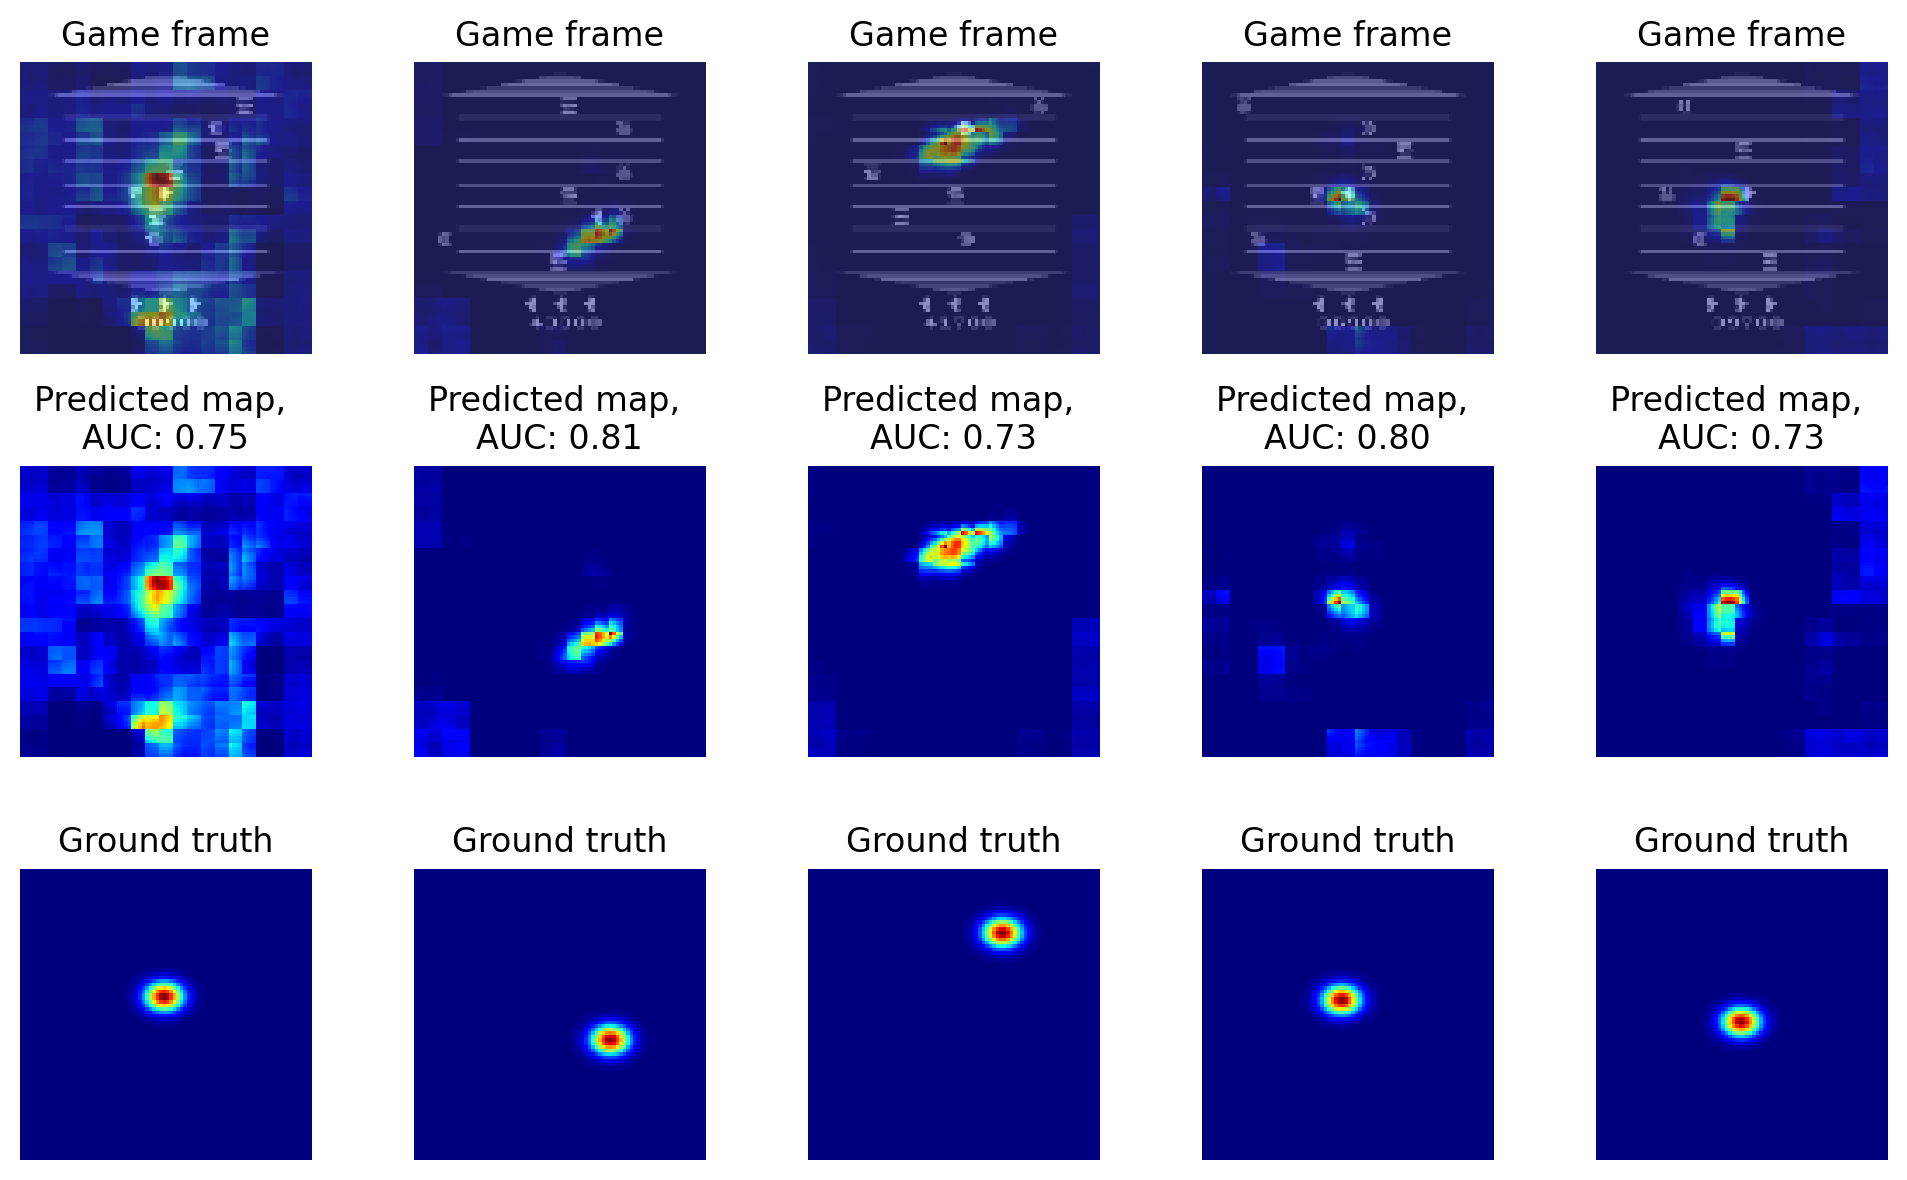

In [15]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))
ax = ax.ravel()
for frames, labels in train_ds.take(1):
    predictions = model.predict(frames)
    for i in range(5):
        auc_score = heatmap_comparison_using_AUC(labels[i], predictions[i])
        
        ax[i].imshow(frames[i][-1], cmap='gray', alpha=.8)
        ax[i].set_title('Game frame')
        ax[i].axis("off")
        
        ax[i].imshow(predictions[i], cmap='jet', alpha=.45)
        ax[i].axis("off")

        ax[5 + i].imshow(predictions[i], cmap='jet')
        ax[5 + i].set_title(f'Predicted map, \nAUC: {auc_score:.2f}')  
        ax[5 + i].axis("off")
        
        ax[10 + i].imshow(labels[i], cmap='jet')
        ax[10 + i].set_title('Ground truth')
        ax[10 + i].axis("off")
fig.tight_layout()

In [ ]:
plt.plot(hist['loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Test loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(epochs, step=50))
plt.legend()
plt.show()

1/1 [==============================] - 0s 8ms/step


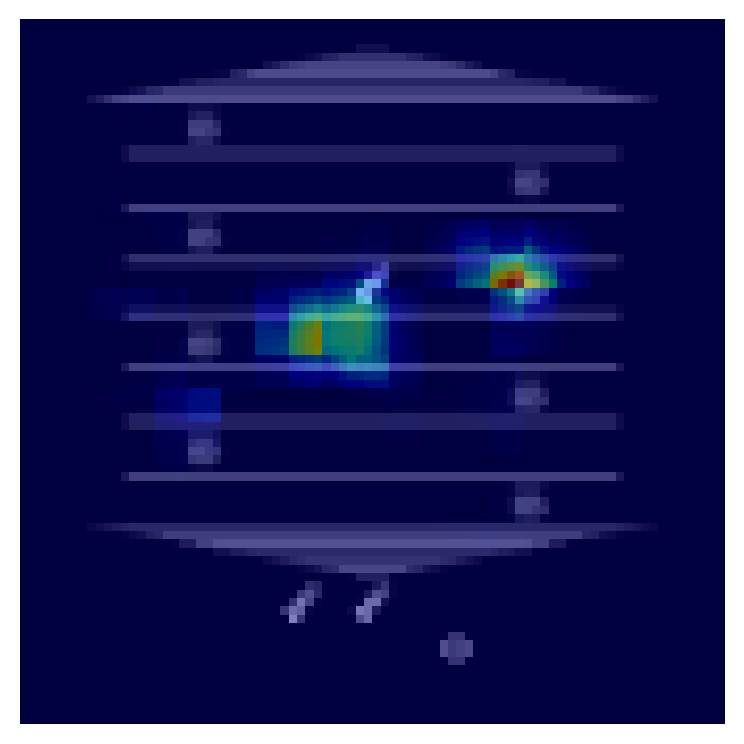

In [12]:
import gym
from gym.wrappers import FrameStack, AtariPreprocessing

env = gym.make('ALE/Asterix-v5', frameskip=1)
env = AtariPreprocessing(env, frame_skip=4)
# frame stacking with 4 frames
env = FrameStack(env, num_stack=4)
obs = env.reset()
for i in range(5):
    obs, reward, done, info = env.step(0)

fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(obs[-1], cmap='gray')
plt.axis("off")

obs = tf.cast(obs, tf.float32)
obs = tf.expand_dims(obs, axis=0) # add batch dim

predicted_gaze = model.predict(obs)

plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(predicted_gaze).numpy(), cmap='jet', alpha=.5)
plt.axis("off");

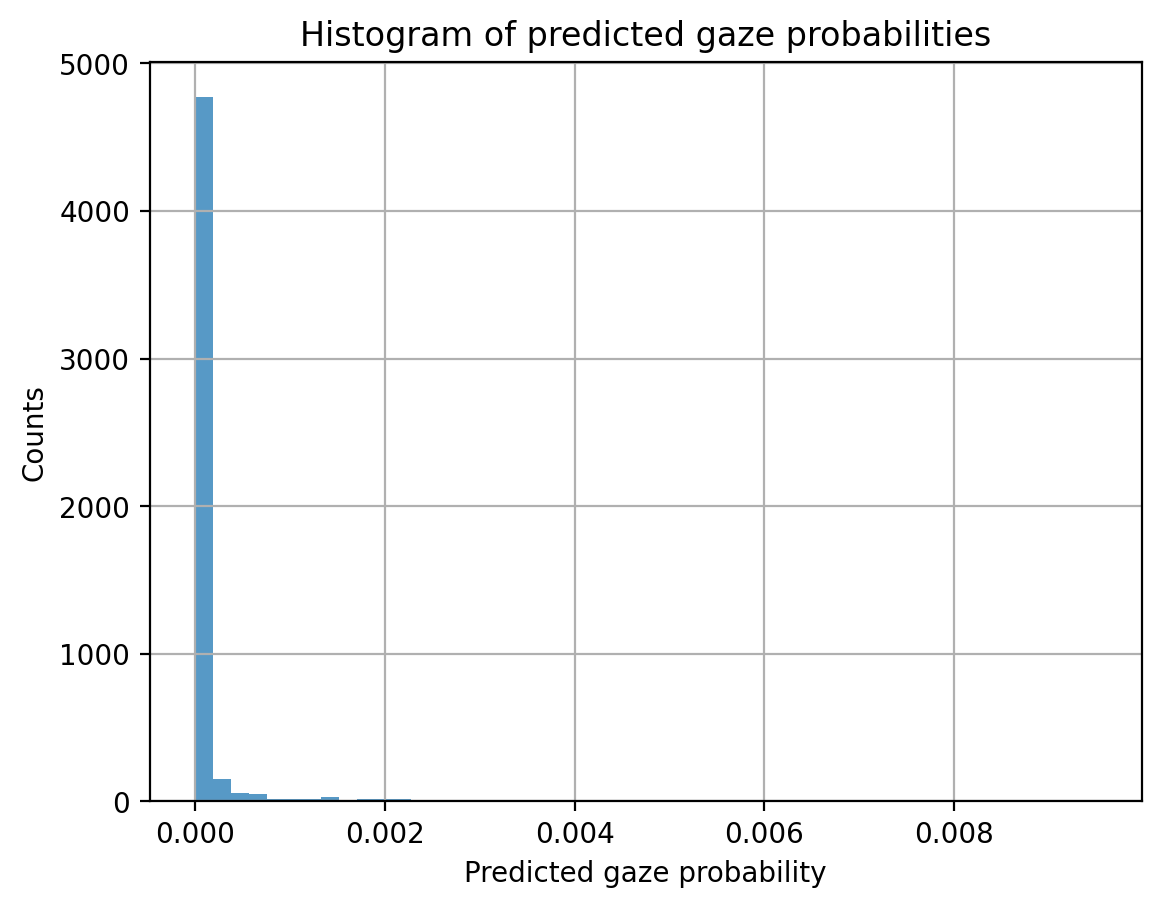

In [13]:
# histogram of gaze probabilities predicted by the model
n, bins, patches = plt.hist(predicted_gaze.flatten(), 50, density=True, alpha=.75)


plt.xlabel('Predicted gaze probability')
plt.ylabel('Counts')
plt.title('Histogram of predicted gaze probabilities')
plt.grid(True)
plt.show()

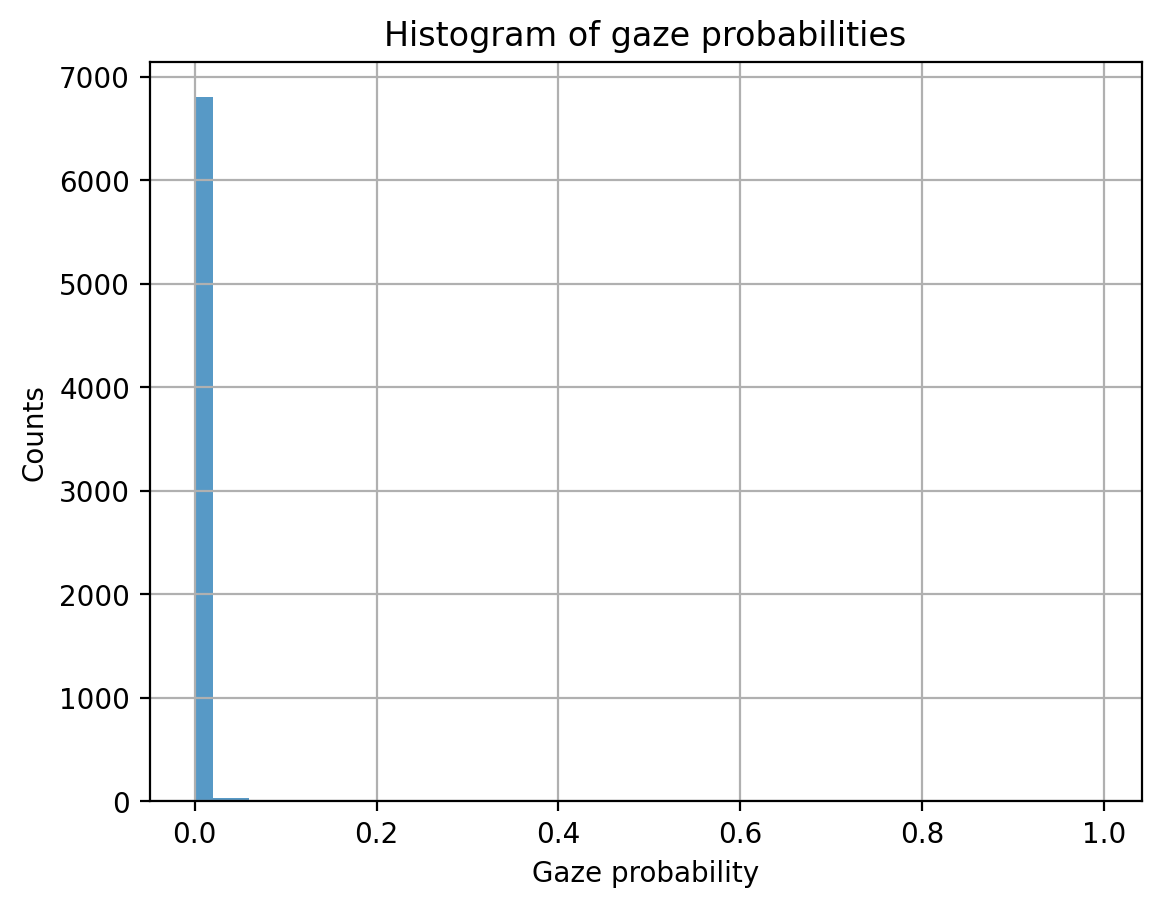

In [14]:
# histogram of gaze probabilities from a random gaze map from the dataset
for _, heatmaps in val_ds.take(1):
    n, bins, patches = plt.hist(heatmaps[0].numpy().flatten(), 50, alpha=.75)


plt.xlabel('Gaze probability')
plt.ylabel('Counts')
plt.title('Histogram of gaze probabilities')
plt.grid(True)
plt.show();